# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [61]:
!pip install -U scikit-learn 

In [62]:
!pip install phik

In [63]:
import pandas as pd
import numpy as np
import warnings
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean 

from numpy.random import RandomState

### Загрузка данных

Данные геологоразведки трёх регионов находятся в датасетах ниже.

Обозначение признаков:
id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек;
product — объём запасов в скважине (тыс. баррелей).

In [64]:
warnings.filterwarnings('ignore')

geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.name = 'geo_data_0'
display(geo_data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [65]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.name = 'geo_data_1'
display(geo_data_1.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [66]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.name = 'geo_data_2'
display(geo_data_2.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Никаких аномалий не обнаружено, столбцы называются одинаково

### Проверка типов данных и попусков

In [67]:
lst = [geo_data_0, geo_data_1, geo_data_2]

for l in lst:
    print(l.name)
    l.info()
    print()

geo_data_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

geo_data_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

geo_data_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 

Типы данных указаны верно, пропусков нет

### Поиск дубликатов

In [68]:
for l in lst:
    print(l.name)
    print('количество явных дубликатов:',l.duplicated().sum())
    l.drop_duplicates(inplace=True)

geo_data_0
количество явных дубликатов: 0
geo_data_1
количество явных дубликатов: 0
geo_data_2
количество явных дубликатов: 0


Явных дубликатов нет, проверку на неявные проводить не нужно

### Изменение индексов

In [69]:
for l in lst:
    l = l.set_index('id')
    display(l.head(1))

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.22117,105.280062


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276,-0.005876,3.179103


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673


id успешно переведен в индекс

### Исследовательский анализ данных

Посмотрим распределение значений

In [70]:
for l in lst:
    print(l.name)
    display(l.describe())
    print()

geo_data_0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



geo_data_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



geo_data_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Стандартное целевого признака product совпадает для всех датасетов, что говорит о возможности применения одних и тех же методов обработки данных. Различие f0,f1,f2 обусловлено изначальными условиями.

Для второго региона(geo_data_1) видно сильное отставание по целевому признаку.

Создадим функцию для построения графиков

In [71]:
def pl(data,col):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=data,x=col)
    plt.subplot(1, 2, 2)
    plt.boxplot(data[col])
    plt.title(col);

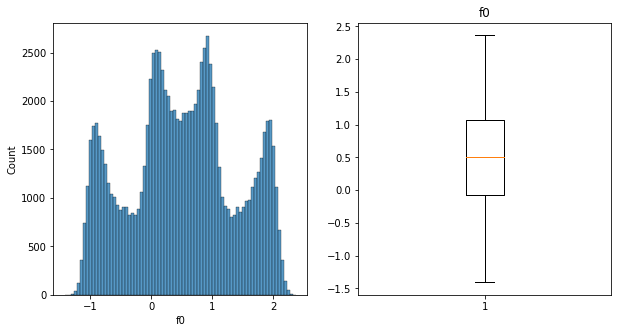

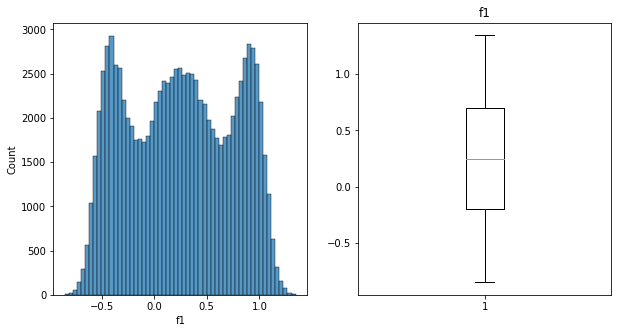

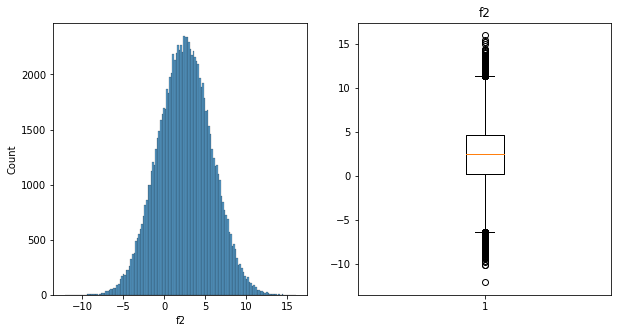

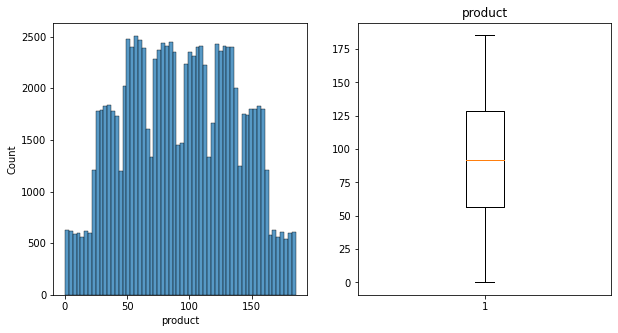

In [72]:
for column in geo_data_0.drop(columns='id').columns:
    pl(geo_data_0, column)

In [73]:
geo_data_0 = geo_data_0.query('(f2 < 12)&(f2 > -7)')
geo_data_0.shape[0]

99753

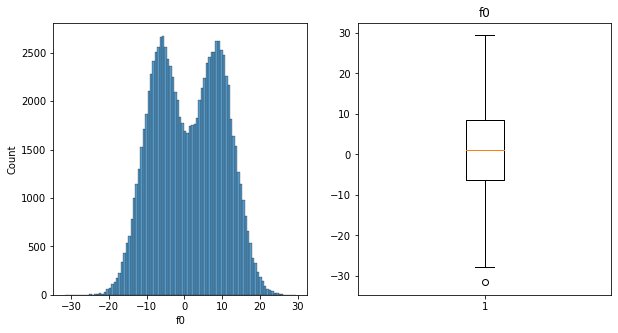

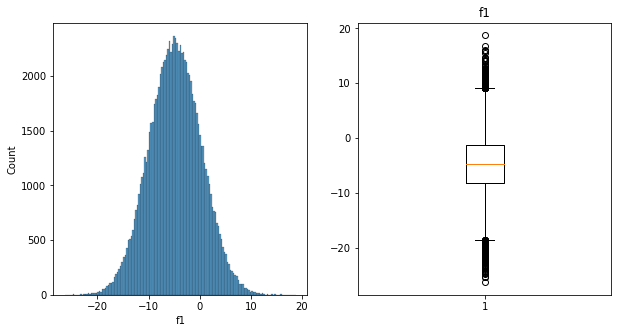

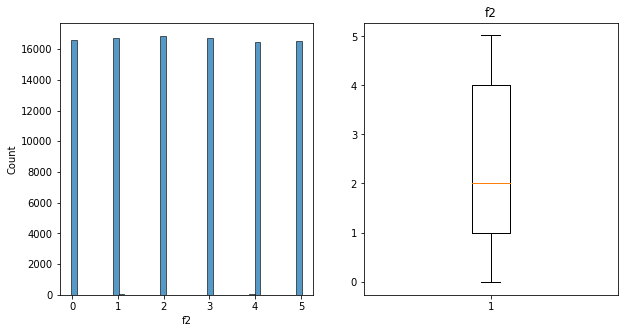

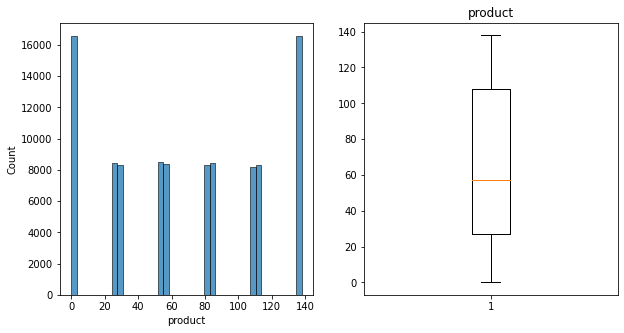

In [74]:
for column in geo_data_1.drop(columns='id').columns:
    pl(geo_data_1, column)

In [75]:
geo_data_1 = geo_data_1.query('(f1 > -20)&(f1 < 10)&(f0 > -30)')
geo_data_1.shape

(99672, 5)

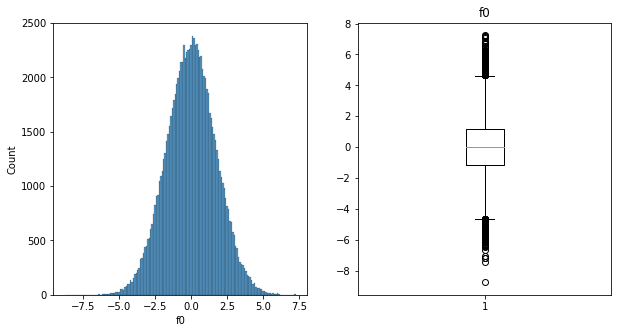

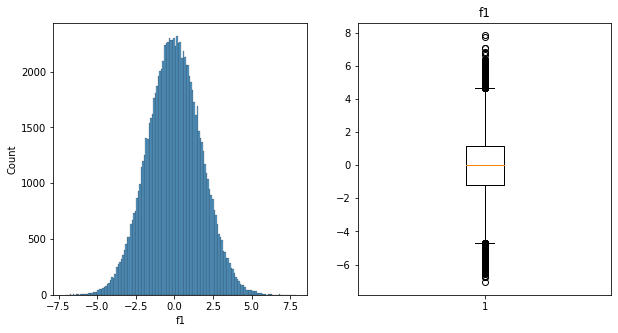

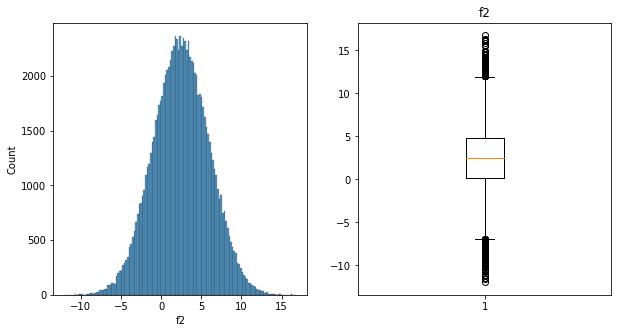

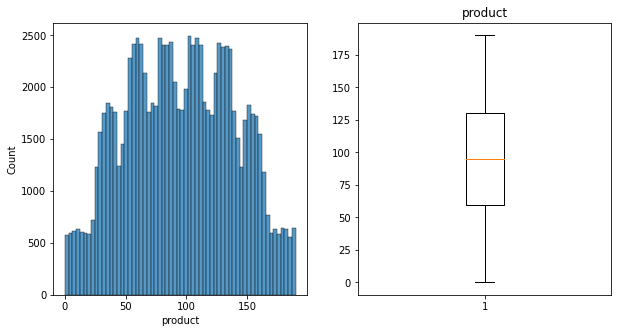

In [76]:
for column in geo_data_2.drop(columns='id').columns:
    pl(geo_data_2, column)

In [77]:
geo_data_2 = geo_data_2.query('(f0 < 5)&(f0 > -5)&(f1 < 5)&(f1 > -5)&(f2 > -7)&(f2 < 12)')
geo_data_2.shape

(98666, 5)

Распределение признаков f0, f1, f2 не совпадает.

Видна прямая зависмость целевого признака от f2.

Выбросы решено удалить для улучшения предсказания линейной модели. Самая большая доля удаленных данных равна 1,33%, что является допустимым значением.

### Корреляционный анализ

Создадим функцию для построения матрицы корреляции.

In [78]:
def cor(data):
#    plt.figure(figsize=(12, 10))
#    sns.heatmap(data.corr(method='spearman'),annot=True, fmt='.2f', cmap='coolwarm');
#    plt.title(data.name)
    
    phik_overview = data.phik_matrix();
    plot_correlation_matrix(phik_overview.values,
                            x_labels=phik_overview.columns,
                            y_labels=phik_overview.index,
                            figsize=(10,8)
                            );
    plt.tight_layout();
  #  plt.title(data.name)
    
    sns.pairplot(data);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


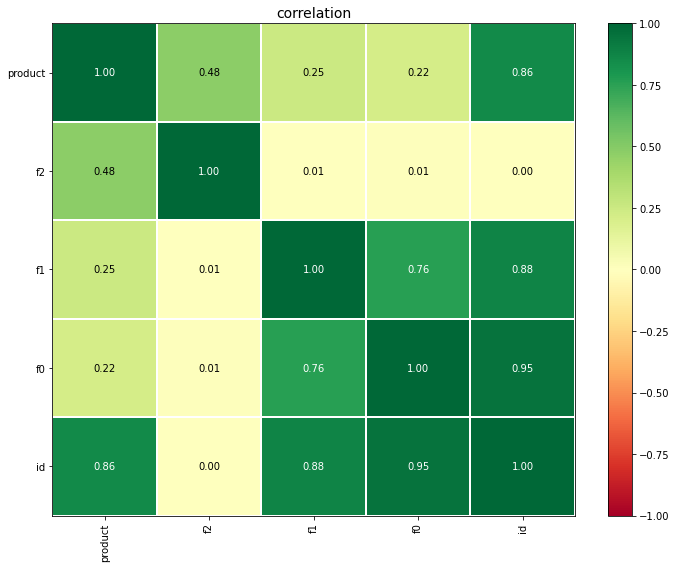

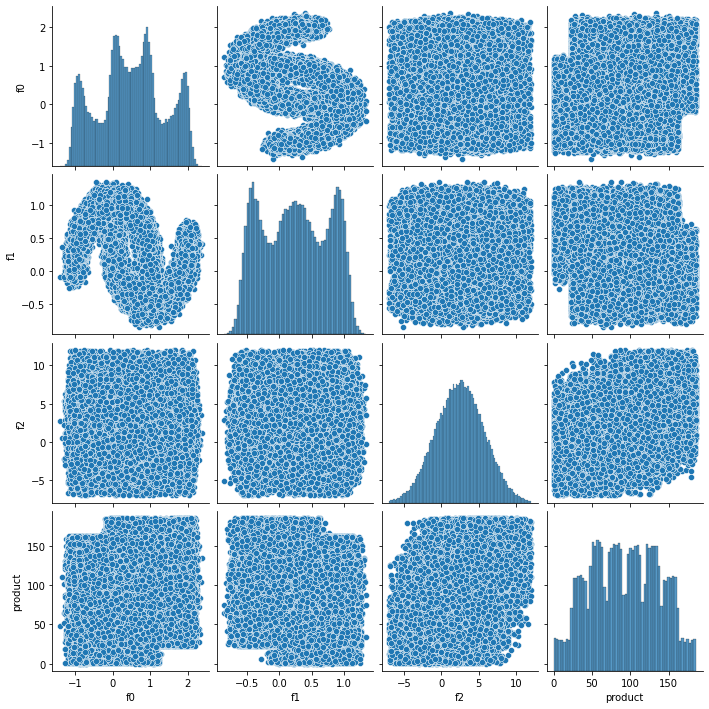

In [79]:
cor(geo_data_0)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


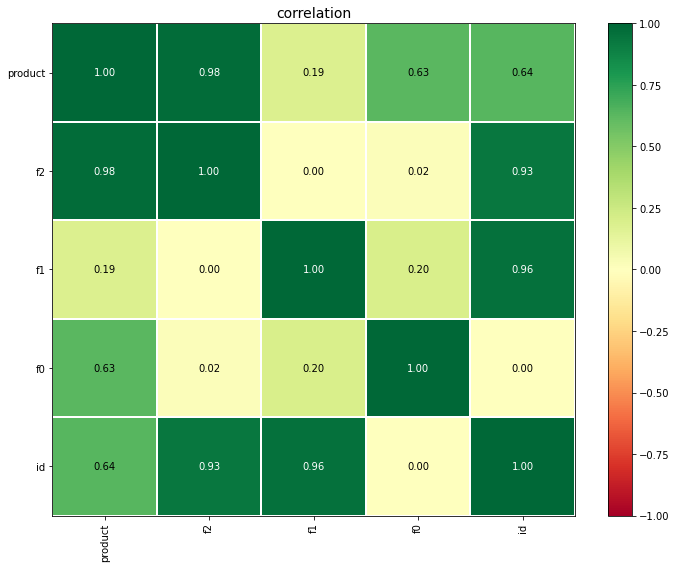

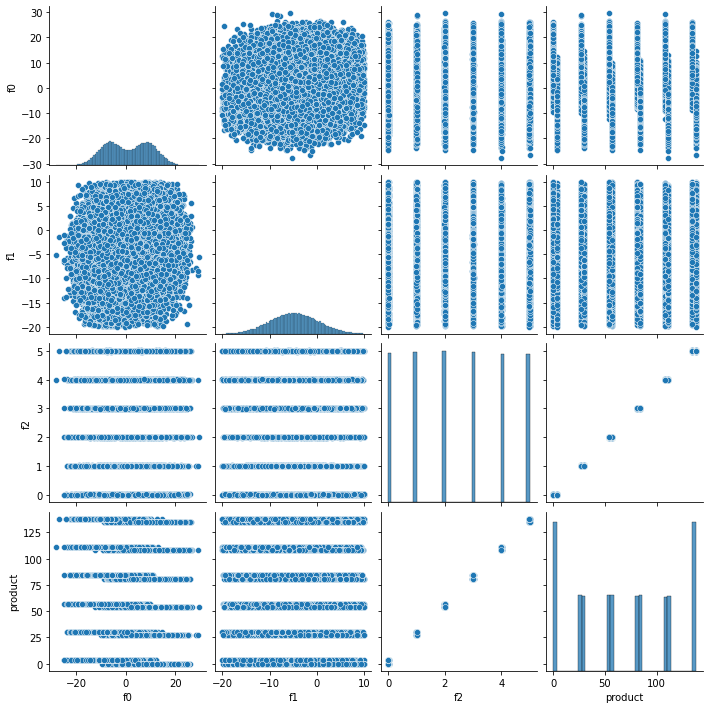

In [80]:
cor(geo_data_1)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


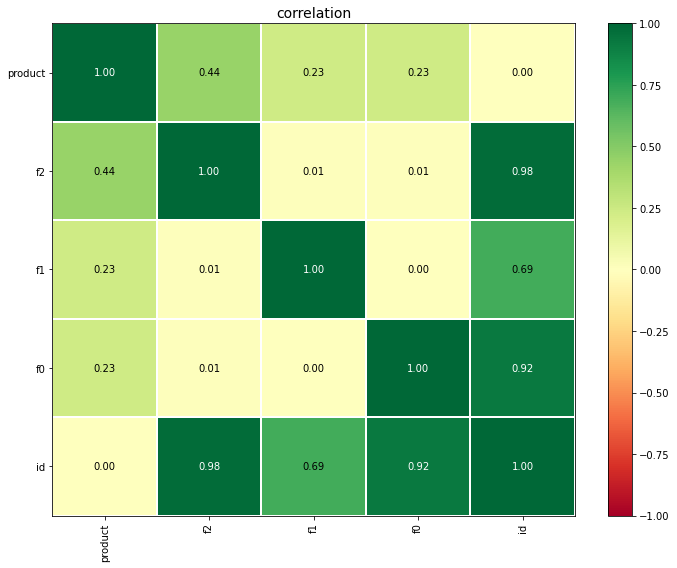

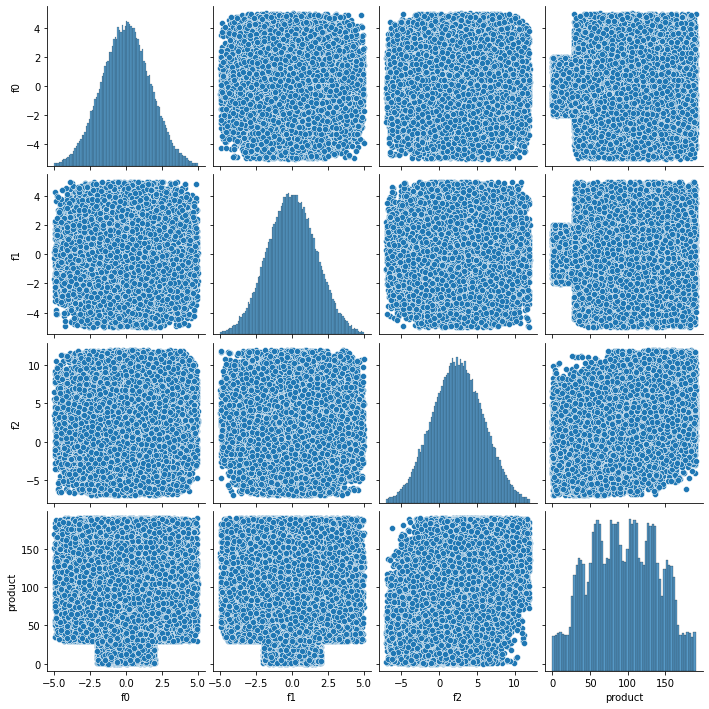

In [81]:
cor(geo_data_2)

Из анализа видно, что признак f2 не взаимодействует с f0 и f1. Также в датасете geo_data_1 заметно, что признак f2 очень сильно влияет на целевой, что может повлиять на обучение модели.

При таких условиях лучше всего будет обучить модель для каждого региона отдельно.

### Вывод
При предобработке данных не были найдены проблемы. ID переведен в индекс

Выбросы удалены

При анализе были найдены отличия распределений для каждого региона, поэтому приянто решение постороить несколько моделей.

## Обучение и проверка модели

Главные требование к модели были выдвинуты изначально:
- обучающая и валидационная выборка имеют соотнешение 75/25
- для обучения модели можно использовать линейную регрессию, так как важна предсказуемость модели
- Для оценки модели необходимо использовать метрику RMSE

In [82]:
clf = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('LinReg', LinearRegression())
                     ])

In [83]:
def mLR(data):
    data = data.set_index('id')
    X = data.drop(columns=['product'])
    y = data['product']
    
    RANDOM_STATE = 45
    TEST_SIZE = 0.25

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size = TEST_SIZE ,
        random_state = RANDOM_STATE,
    )
    
    model = clf
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid, pred, squared = False)
    r2 = r2_score(y_valid, pred)
    mean_pred = pred.mean()
    
    print("RMSE",round(rmse, 3))
    #print("R2", round(r2, 3))
    print("Среднее значение количества предсказанного сырья, тыс.бареллей:", mean_pred)
    
    return model, pred, X_valid, y_valid, mean_pred

In [84]:
geo_data_0_1 = geo_data_0
model_0, pred_0, X_val_0, y_val_0, mean_0 = mLR(geo_data_0)

RMSE 37.638
Среднее значение количества предсказанного сырья, тыс.бареллей: 92.54994056713853


In [85]:
geo_data_1_1 = geo_data_1
geo_data_1_1['f2'] = geo_data_1_1['f2']**2
model_1, pred_1, X_val_1, y_val_1, mean_1 = mLR(geo_data_1_1)

RMSE 12.955
Среднее значение количества предсказанного сырья, тыс.бареллей: 68.65180557405039


In [86]:
geo_data_2_1 = geo_data_2
model_2, pred_2, X_val_2, y_val_2, mean_2 = mLR(geo_data_2_1)

RMSE 40.026
Среднее значение количества предсказанного сырья, тыс.бареллей: 94.89905645576039


### Обработка предсказанных значений

Добавим предсказанные значения к валидационной выборке

In [87]:
def df_pred(X_val, y_val, pred):
    data = X_val
    data['product'] = y_val
    data['pred_product'] = pred
    return data

In [88]:
geo_data_0_val = df_pred(X_val_0, y_val_0, pred_0)
geo_data_0_val.head()

,f0,f1,f2,product,pred_product
id,,,,,
1Dm8s,-0.880105,0.530670,3.263015,60.722812,88.352726
8Jy2g,1.523498,-0.401039,-2.619109,75.878954,71.461248
DOQph,-0.392318,1.033027,0.859638,39.242578,66.967127
m4OZh,0.546559,0.813040,-0.965823,9.891084,61.455599
QXmof,0.467802,-0.454378,3.697631,155.618300,110.380192


In [89]:
geo_data_1_val = df_pred(X_val_1, y_val_1, pred_1)
geo_data_1_val.head()

,f0,f1,f2,product,pred_product
id,,,,,
yUYrt,-7.353128,-2.575502,0.000002,3.179103,24.690838
Jx1VH,9.504878,-6.626532,24.926850,134.766305,146.121270
edLcX,8.232052,2.460714,15.982856,107.813044,101.657394
rwYzg,7.681311,-3.745449,0.000048,0.000000,22.607592
nIMxo,9.968658,-8.425880,24.975586,134.766305,146.349843


In [90]:
geo_data_2_val = df_pred(X_val_2, y_val_2, pred_2)
geo_data_2_val.head()

,f0,f1,f2,product,pred_product
id,,,,,
LJ3xI,0.718257,1.478586,-0.922734,41.919717,75.100948
or2ix,0.803582,1.005679,1.506994,120.940290,89.116283
cOHrq,4.242231,-3.119878,1.784295,39.234157,90.528721
RZdjd,-1.395907,-1.311847,2.050962,122.370143,92.323374
A19Bp,1.300664,-0.061354,5.387396,150.087665,111.481072


### Вывод

Для второй модели принято решение возвести признак f2 в степень. Это позволило избежать переобучения модели, так как изначально корреляция f2 с целевым составила 0,98 и нет возможности удаления признака.`

## Подготовка к расчёту прибыли

Сохраним переменные для расчета прибыли и найдем минимальный объем сырья для одной скважины.

In [91]:
BUDGET = 10000000 #значение указано в тыс. рублей
INCOME = 450 #доход с одной баррели сырья

min_product = BUDGET/INCOME
print('Минимальный объем сырья, в тыс.баррелей, для безубыточной разработки скважин:', round(min_product/200, 2))

Минимальный объем сырья, в тыс.баррелей, для безубыточной разработки скважин: 111.11


Исходя из среднего значения, найдем минимальное количество скважин в каждом регионе:

In [92]:
for mean in [mean_0, mean_1, mean_2]:
    print('Минимальное количество скважин в регионе:', round(min_product/mean))

Минимальное количество скважин в регионе: 240
Минимальное количество скважин в регионе: 324
Минимальное количество скважин в регионе: 234


In [93]:
for volume in [geo_data_0_val,geo_data_1_val, geo_data_2_val]:
    print('Среднее количество сырья в одной скважине:', round(volume['pred_product'].mean()))

Среднее количество сырья в одной скважине: 93
Среднее количество сырья в одной скважине: 69
Среднее количество сырья в одной скважине: 95


Видно, что ни в одном из регионов не достигается минимальное среднее значение(111)

Добавим столбец с прибылью, в тыс.р., полученной с каждой скважины.

In [94]:
geo_data_0_val['profit_sum_pred'] = geo_data_0_val['pred_product']*450
geo_data_0_val['profit_sum_targ'] = geo_data_0_val['product']*450

geo_data_1_val['profit_sum_pred'] = geo_data_1_val['pred_product']*450
geo_data_1_val['profit_sum_targ'] = geo_data_1_val['product']*450

geo_data_2_val['profit_sum_pred'] = geo_data_2_val['pred_product']*450
geo_data_2_val['profit_sum_targ'] = geo_data_2_val['product']*450

Напишем функцию для расчёта прибыли. Она возвращает информацию о 200 лучших, по объему сырья, скважин, а также показывает в них объем сырья и возмождную прибыль. 

In [95]:
def profit_200(data_val):
    best_200 = data_val.sort_values(by = 'pred_product', ascending = False).head(200)
    sum_best_200 = best_200['pred_product'].sum()
    print('Объем сырья в 200 лучших скважин:', round(sum_best_200, 2))
    profit = sum_best_200*450 - BUDGET
    print('Прибыль, в тыс. рублей:', round(profit, 2))
    return best_200

### Вывод

Создана функция для оценки прибыльности лучших 200 скважин. 
По результатам подготовки видно, что регионы 0 и 2 обладают лучшим потенциалом для разработки месторождений.

## Расчёт прибыли и рисков 

Для предварительной оценки найдем 200 лучших скважин по объему сырья в каждом регионе.

In [96]:
geo_0_best_200 = profit_200(geo_data_0_val)

Объем сырья в 200 лучших скважин: 30717.87
Прибыль, в тыс. рублей: 3823043.6


In [97]:
geo_1_best_200 = profit_200(geo_data_1_val)

Объем сырья в 200 лучших скважин: 29997.57
Прибыль, в тыс. рублей: 3498907.18


In [98]:
geo_2_best_200 = profit_200(geo_data_2_val)

Объем сырья в 200 лучших скважин: 28858.56
Прибыль, в тыс. рублей: 2986350.25


По значениям видно, что начальная оценка может быть ошибочной. Регионы 0 и 1 показали лучшие результаты.

Для более точной оценки применим распределение прибыли применим bootstrap, с помощью которого найдем среднее значение прибыли, доверительный интервал и вероятность убытков. Перед созданием функции объявим переменные:

In [99]:
def bootstrap(data):
    state = np.random.RandomState(45)
    values = []
    count_min = 0 #переменная для подсчета выборок с убытком
    
    BOOTSTRAP_SAMPLES = 1000
    PROB_OF_LOSS = 2.5 # вероятность убытка(2,5%)
    
    for i in range(BOOTSTRAP_SAMPLES):
        target_sample = data.sample(n = 500, replace=True, random_state=state)
        val_200 = target_sample.sort_values(by='profit_sum_pred',ascending = False).head(200)
        val_sum = val_200['profit_sum_targ'].sum()
        values.append(val_sum)
        if val_sum < BUDGET:
            count_min += 1
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print('Среднее значение прибыли в регионе:',round(values.mean()-BUDGET,2))
    print('Границы доверительного интервала:', round(lower,2),round(upper,2))
    print(f'Прибыль в пределах границ доверительного интервала составит \
          от {round(lower-BUDGET,2)} до {round(upper-BUDGET,2)}')
    
    fraction_loss = count_min*100/BOOTSTRAP_SAMPLES
    print('Вероятность убытка равна:', fraction_loss,'%')
    #print(count_min)

In [100]:
bootstrap(geo_data_0_val)

Среднее значение прибыли в регионе: 415145.99
Границы доверительного интервала: 9924095.81 10914908.84
Прибыль в пределах границ доверительного интервала составит           от -75904.19 до 914908.84
Вероятность убытка равна: 4.6 %


In [101]:
bootstrap(geo_data_1_val)

Среднее значение прибыли в регионе: 429754.48
Границы доверительного интервала: 10018951.64 10849482.69
Прибыль в пределах границ доверительного интервала составит           от 18951.64 до 849482.69
Вероятность убытка равна: 2.0 %


In [102]:
bootstrap(geo_data_2_val)

Среднее значение прибыли в регионе: 404591.54
Границы доверительного интервала: 9880318.41 10876177.19
Прибыль в пределах границ доверительного интервала составит           от -119681.59 до 876177.19
Вероятность убытка равна: 6.0 %


Наименьшая вероятность убытка у региона 1, она равна 2%, что удволетворяет условиям заказчика. Также регион 1 обладает наибольшей средней прибылью, что делает его лучшим выбором.

## Вывод

В ходе работы были получены и проверены 3 датасета с данными для выбора локации. По результатам проверки ошибки не обнаружены.
Да
При анализе были найдены и удалены выбросы в данных. Часть гистограмм не имеют нормального распределения, из-за чего было принято решение использовать phik-матрицу корреляции. Ее результаты показали, что признак f2 обладает сильной зависимостью с целевым для датасета geo_data_1.

Из-за разных зависимостей для каждого набора данных строилась своя модель линейной регрессии. Для датасеат geo_data_1 приянто решение возвести признак f2 в квадрат, чтобы избежать переобучения модели.

Предсказание было сделано на валидационной выборке(0.25 от общего объема датасета). К валидационной выборке добавлены столбцы с целевым и предсказанным значением, а также прибыль(в тыс. р.), расчитанная по предсказанному значению.

При условии, что бюджет на разработку равен 10 млрд.р., получено значение минимального объема сырья в скважине, равное 111 тыс.баррелей. Среднее значение сырья в скважине по регионам меньше необходимого.

Для изначальных условий:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Регионы не должны иметь вероятность убытка больше 2,5%
- Бюджет на разработку равен 10 млрд. р.

был проведена процедура бутстрепа, где был найден лучший регион для разработки.

Данным условиям не отвечает регион 1.
Наименьшие риски несет регион 1 (2% вероятности убытка). Ожидаемая средняя прибыль с него 429754480 рублей. Границы интервала возможной прибыли: от 18951.64 до 849482.69